# Logistic Regression Classifier

The goal of this notebook is to classify our samples using a Logistic Regression model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)




In [2]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap

from sklearn.linear_model import LogisticRegression

In [3]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [23]:
def average_speakers(mfcc_df):
    
    feature_cols = [x for x in mfcc_df.columns if 'mfcc_median' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'phoneme'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined, feature_cols




def load_data():
    train = pd.read_csv('../../../data/train_formants_phonemes.csv')
    test = pd.read_csv('../../../data/test_formants_phonemes.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train, feature_cols = average_speakers(train)
    
    british_df = pd.read_csv('../../../data/british_formants_phonemes.csv')
    feature_cols = [x for x in british_df.columns if 'mfcc_median' in x]
    
    return train, test, british_df[feature_cols], feature_cols


train, test, british_df, feature_cols = load_data()

In [24]:
british_df.head()

,mfcc_median_1,mfcc_median_2,mfcc_median_3,mfcc_median_4,mfcc_median_5,mfcc_median_6,mfcc_median_7,mfcc_median_8,mfcc_median_9,mfcc_median_10,mfcc_median_11,mfcc_median_12
0,272.330770,-8.595469,38.280541,-9.332285,-33.662383,-16.696240,-44.373869,30.528335,43.265023,-12.658478,2.939703,-45.539513
1,234.689936,7.647177,61.076451,24.944757,-38.814549,-16.006891,-47.088980,34.107574,38.258621,-8.202258,-0.152856,-28.319855
2,310.780165,-5.903211,-11.727140,-53.900031,-0.840551,43.646544,-53.549718,-7.294380,-4.880976,8.120048,-1.609176,-10.360692
3,283.586890,-33.794160,-23.530823,-11.672208,5.818331,13.332588,-28.107817,-0.586760,5.310681,-7.237384,6.491864,-28.225484
4,228.585736,36.346397,68.726927,21.968284,-39.815117,-37.496932,-58.202005,31.824670,20.070525,-8.954472,1.788237,-7.906751


In [15]:
train.head()

,speaker,phoneme,mfcc_median_1,mfcc_median_2,mfcc_median_3,mfcc_median_4,mfcc_median_5,mfcc_median_6,mfcc_median_7,mfcc_median_8,mfcc_median_9,mfcc_median_10,mfcc_median_11,mfcc_median_12,accent
0,FAEM0,aa,257.883645,-112.555597,-86.220083,-50.271755,3.079204,-5.562003,-26.631936,29.764815,-27.643056,10.231153,-34.380283,-7.140240,DR2
1,FAEM0,ae,184.540988,-101.264124,20.184421,-65.233988,-58.582363,-2.225008,-0.678909,25.271649,-30.760208,8.738763,-26.511251,6.101677,DR2
2,FAEM0,ah,219.272779,-83.626224,-64.816535,-104.352116,-9.288058,9.723022,-24.519672,0.941554,-24.264161,1.370557,-50.845472,5.135265,DR2
3,FAEM0,ao,282.929808,-52.180998,-80.782587,-103.281453,-15.977900,40.787098,-28.712984,1.708404,-32.963508,14.709629,-7.342895,-10.294335,DR2
4,FAEM0,aw,216.890160,-98.217040,-56.656631,-92.011346,-27.605560,4.129498,-17.425102,16.674520,-29.656561,4.851841,-64.782092,12.218158,DR2


In [26]:
test.shape # 13596

test.loc[test['phoneme'].isin(train['phoneme'])].shape

(42195, 44)

In [27]:
test.accent.value_counts()

DR4    12207
DR5     6510
DR3     6426
DR2     6265
DR7     5445
DR1     2691
DR6     2651
Name: accent, dtype: int64

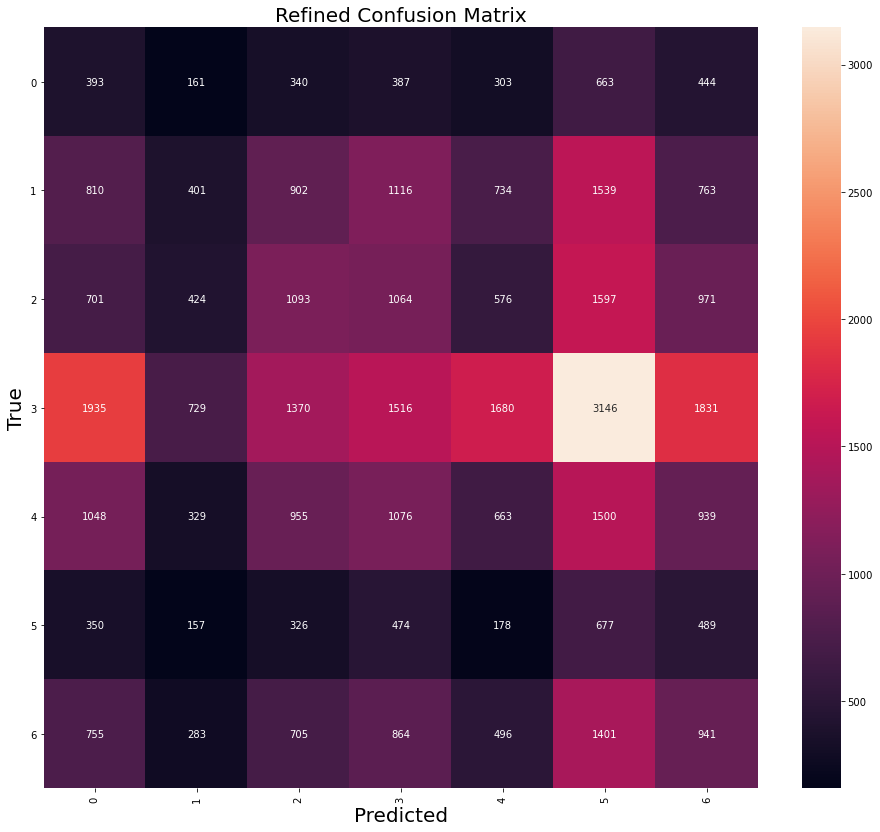

Logistic Reg Number of mislabeled points out of a total 42195 points : 36511
                   DR1          DR2          DR3           DR4          DR5  \
precision     0.065587     0.161433     0.192058      0.233338     0.143197   
recall        0.146042     0.064006     0.170090      0.124191     0.101843   
f1-score      0.090522     0.091668     0.180408      0.162104     0.119031   
support    2691.000000  6265.000000  6426.000000  12207.000000  6510.000000   

                   DR6          DR7  accuracy     macro avg  weighted avg  
precision     0.064335     0.147538  0.134708      0.143927      0.170080  
recall        0.255375     0.172819  0.134708      0.147767      0.134708  
f1-score      0.102778     0.159181  0.134708      0.129384      0.139118  
support    2651.000000  5445.000000  0.134708  42195.000000  42195.000000  


In [28]:
def logistic_reg(train, test, display_conf=True, word=None, features = None):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'mfcc_median' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
        
    logit = LogisticRegression(max_iter = 1250, class_weight='balanced', C=0.01)
    logit.fit(X_train, y_train)
    
    y_pred = logit.predict(X_test)
    
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))

    if display_conf:
        conf_mat = confusion_matrix(y_test, y_pred)
        plot_conf_matconf(conf_mat)
    
        print("Logistic Reg Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))    
        print(conf_df)
    
    
    return logit, y_pred, conf_df


logit_whole, logit_y_pred_whole, logit_conf_whole = logistic_reg(train, test)



In [29]:
british_pred = logit_whole.predict(british_df)

In [30]:
whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR4    61692
DR7    50071
DR2    24513
DR6    23449
DR1    21135
DR3    12707
DR5    12345
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
DR1,21135,10.264093
DR2,24513,11.904600
DR3,12707,6.171083
DR4,61692,29.960371
DR5,12345,5.995280
DR6,23449,11.387874
DR7,50071,24.316698


In [41]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test


In [42]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      4003
North    3376
South    1923
West     1552
Name: accent, dtype: int64

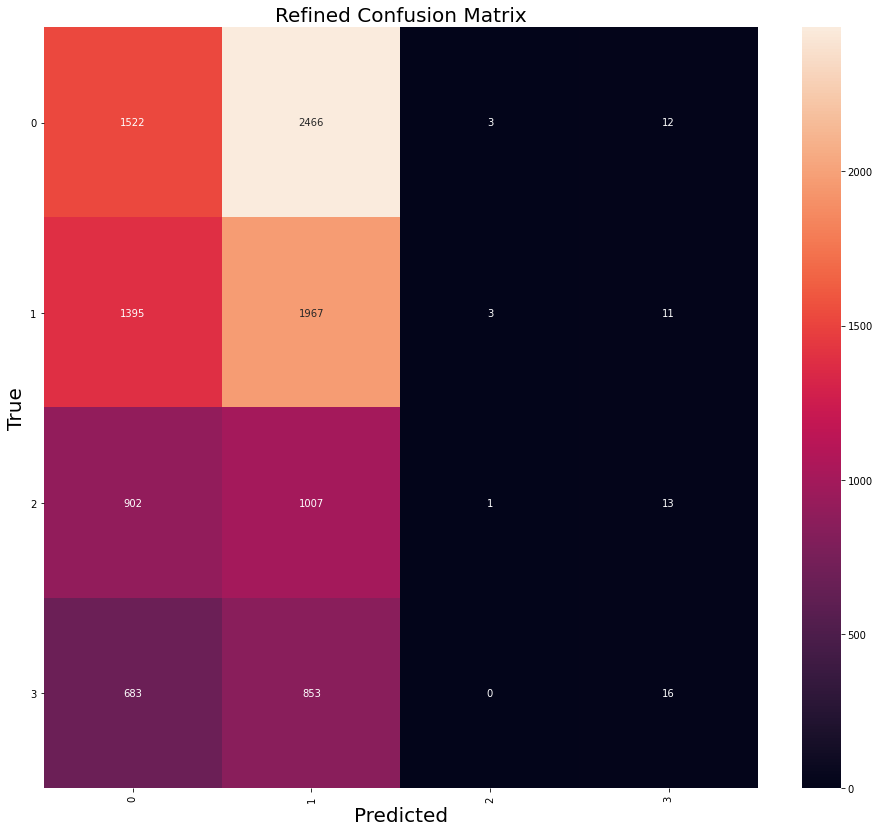

Logistic Reg Number of mislabeled points out of a total 10854 points : 7348
                   Mid        North        South         West  accuracy  \
precision     0.338072     0.312570     0.142857     0.307692  0.323015   
recall        0.380215     0.582642     0.000520     0.010309  0.323015   
f1-score      0.357907     0.406867     0.001036     0.019950  0.323015   
support    4003.000000  3376.000000  1923.000000  1552.000000  0.323015   

              macro avg  weighted avg  
precision      0.275298      0.291210  
recall         0.243422      0.323015  
f1-score       0.196440      0.261585  
support    10854.000000  10854.000000  


In [43]:
logit_condensed, logit_y_pred_condensed, logit_conf_condensed = logistic_reg(condensed_train, condensed_test)


In [48]:
british_pred = logit_condensed.predict(british_df)


condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)


West     492
North    203
Mid       37
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
Mid,37,5.054645
North,203,27.732240
West,492,67.213115


In [49]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    27407
West     5821
Name: accent, dtype: int64

C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\glenn\miniconda3\envs\cda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


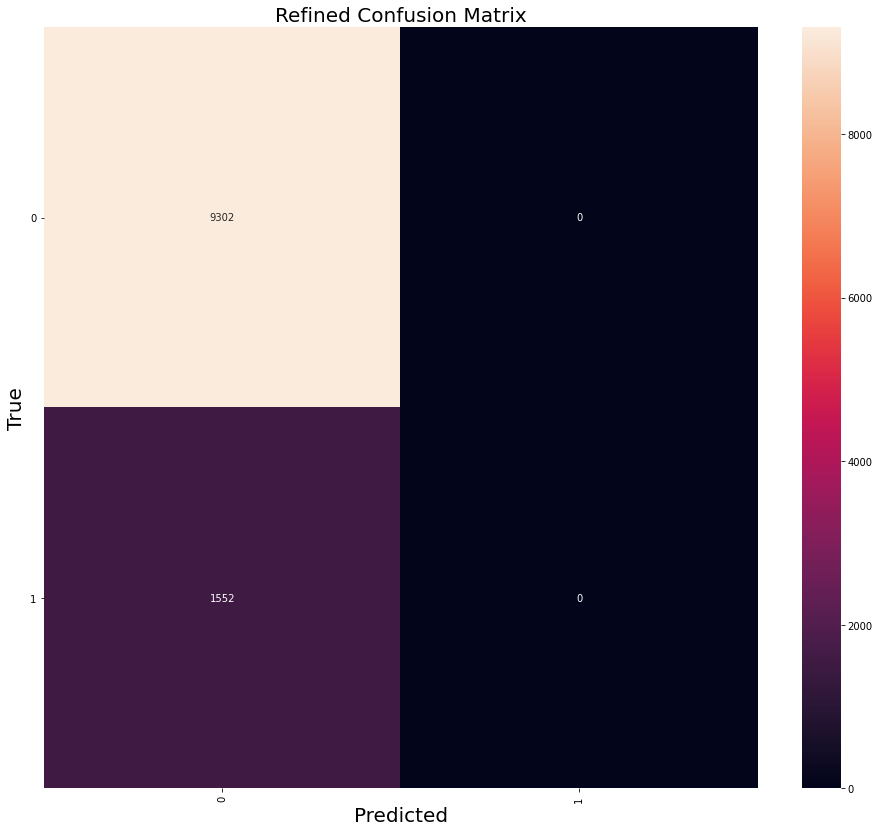

Logistic Reg Number of mislabeled points out of a total 10854 points : 1552
                  East    West  accuracy     macro avg  weighted avg
precision     0.857011     0.0  0.857011      0.428506      0.734468
recall        1.000000     0.0  0.857011      0.500000      0.857011
f1-score      0.923001     0.0  0.857011      0.461500      0.791022
support    9302.000000  1552.0  0.857011  10854.000000  10854.000000


In [50]:
logit_cm, logit_y_pred_cm, logit_conf_cm = logistic_reg(condensed_train_two_regions, condensed_tes_two_regions)


In [51]:
british_pred = logit_cm.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

East    569
West    163
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
East,569,77.73224
West,163,22.26776
